# Combining Invasive Alien Species and Soil Parameters for Predictive Modelling in Southern Italy

**Authors:** Taimur Khan (UFZ) and Spiros Koulouzis (UVA)

### Introduction

This notebook is a part of the BioDT Hackathon. Here we aim to combine species richness maps from the Invasive Alien Species Digital Twin with the soil data building block to explore further opportunities in predictive modelling. We use southern Italy as the study location. The variables in the soil data building block can be used to predict the distribution of invasive species. The aim  is to help the hackathon participants see how different outputs from BioDT can be combined for further downstream analysis.

### IAS and soil paramters

Invasive alien species (IAS) are species that are introduced to a new environment where they are not native, and they have the potential to cause harm to the environment, economy, or human health. The distribution of IAS is influenced by a number of factors, including climate, land use, and soil properties. Soil properties can influence the distribution of IAS by affecting the availability of nutrients, water, and other resources that are essential for the growth and survival of the species.

The soil data building block provides information on a number of soil parameters, including soil Field Capacity, Permanent Wilting Point, Porosity and Saturated Hydraulic Conductivity. These parameters can be used to predict the distribution of IAS by providing information on the availability of water and nutrients in the soil, which are important factors for the growth and survival of IAS.

### Objective

Combine the [IASDT-output.ipynb](../IASDT/IASDT-outputs.ipynb) and [soil.ipynb](../../03-BuildingBlocks/SoilData/soil.ipynb) to download datasets and use them to predict the distribution of invasive species as a function of soil parameters in southern Italy.

Use the code below as a starting point to combine the two datasets and perform the analysis. You can modify the code as needed to explore different aspects of the data and perform additional analyses. Think about what other data sources you could combine with the IAS and soil data to improve the predictive modelling, and how could you create components using the TwinEco framework to create Digital Twins.



## Datasets

**IAS Species Richness**

To keep things simple, we will only work with scrub habitats and the "Cortaderia selloana" (common name: Pampass grass) plant species under current and future climate scenarios.

To reduce complexity, we take a geospatial subset of the data for **southern Italy**.

:::{note}
You do not need to download the IASDT output data to use it. You can stream it with python/R code. An exmaple in python is rovided below. Simply grab the URL from the BioDT OPeNDAP server and use it in your code. http://opendap.biodt.eu/ias-pdt/0/outputs
:::

**Soil Data**

The soil data building block provides information on a number of soil parameters, including soil Field Capacity, Permanent Wilting Point, Porosity and Saturated Hydraulic Conductivity. We generate some soil datasets for randomized points within the study area.

### Let's start

Get Pampass grass species richness map from the server for the current time period only:

In [ ]:
import rioxarray

current_mean = "http://opendap.biodt.eu/ias-pdt/0/outputs/hab3/predictions/Current/Sp_0171_mean.tif"

tif_data = rioxarray.open_rasterio(current_mean)
print(tif_data)

<xarray.DataArray (band: 1, y: 404, x: 390)>
[157560 values with dtype=float32]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 2.635e+06 2.645e+06 ... 6.515e+06 6.525e+06
  * y            (y) float64 5.415e+06 5.405e+06 ... 1.395e+06 1.385e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:       Area
    STATISTICS_MAXIMUM:  0.99995940923691
    STATISTICS_MEAN:     -9999
    STATISTICS_MINIMUM:  0
    STATISTICS_STDDEV:   -9999
    _FillValue:          nan
    scale_factor:        1.0
    add_offset:          0.0
    long_name:           Sp_0171_mean


In [25]:
print(tif_data.rio.crs)
# Convert the CRS to EPSG:4326
tif_data = tif_data.rio.reproject("EPSG:4326")
print(tif_data.rio.crs)

EPSG:3035
EPSG:4326


Slice the data for southern europe:

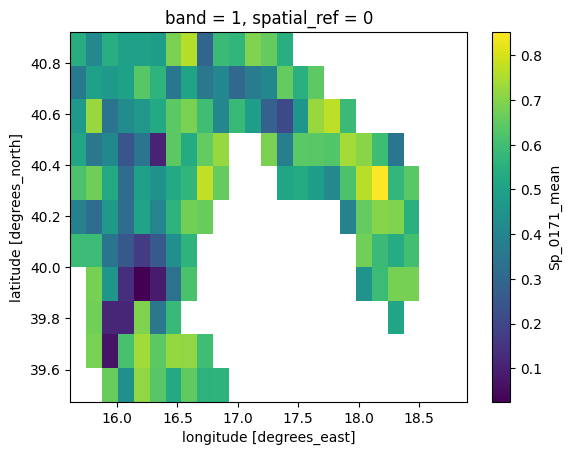

In [26]:
# Define an approximate bounding box for Southern Europe
# (These coordinates are placeholders and may need to be adjusted for your study area)
minx = 15.721436
maxx = 18.803101
miny = 39.537940
maxy = 40.884448

# Clip the data to the defined bounding box using rioxarray's clip_box function
subset = tif_data.rio.clip_box(minx=minx, miny=miny, maxx=maxx, maxy=maxy)

# Plot the clipped data
subset.plot()

Generate random spatial points in the subset area for downloading soil data:


In [27]:
import numpy as np
from pyproj import Transformer

# Get the valid coordinates where the data is not NaN
valid_coords = np.column_stack(np.where(~np.isnan(subset.values[0])))

# Convert the valid coordinates to spatial coordinates
valid_x = subset.x.values[valid_coords[:, 1]]
valid_y = subset.y.values[valid_coords[:, 0]]

# Generate random indices to select random points from the valid coordinates
num_points = 40  # Number of random points to generate
random_indices = np.random.choice(len(valid_coords), num_points, replace=False)

# Select the random points
random_points = np.column_stack((valid_x[random_indices], valid_y[random_indices]))

# Initialize the transformer to convert from the current CRS to EPSG:4326
transformer = Transformer.from_crs(subset.rio.crs, "EPSG:4326", always_xy=True)

# Convert the random points to EPSG:4326
random_points_4326 = np.array([transformer.transform(x, y) for x, y in random_points])

print(random_points_4326)

[[17.51781978 40.5917871 ]
 [16.59809765 40.85456485]
 [16.46670878 40.46039823]
 [18.17476416 40.19762048]
 [16.20393103 40.46039823]
 [15.94115328 40.19762048]
 [15.94115328 39.93484273]
 [15.67837553 40.85456485]
 [16.3353199  39.93484273]
 [15.8097644  40.85456485]
 [16.59809765 39.93484273]
 [16.07254215 39.67206498]
 [16.3353199  39.80345385]
 [15.94115328 40.32900935]
 [17.64920866 40.72317598]
 [15.94115328 40.85456485]
 [16.20393103 40.5917871 ]
 [15.8097644  39.80345385]
 [16.20393103 39.67206498]
 [16.07254215 40.72317598]
 [17.3864309  40.46039823]
 [16.07254215 40.46039823]
 [17.78059753 40.32900935]
 [16.59809765 40.72317598]
 [18.43754191 40.19762048]
 [16.72948653 40.46039823]
 [17.25504203 40.72317598]
 [17.78059753 40.5917871 ]
 [17.25504203 40.85456485]
 [17.64920866 40.32900935]
 [18.30615303 40.19762048]
 [17.25504203 40.46039823]
 [16.3353199  39.5406761 ]
 [18.43754191 40.0662316 ]
 [18.17476416 39.93484273]
 [15.8097644  39.93484273]
 [16.72948653 40.32900935]
 

Plot subset species richness and soil data:

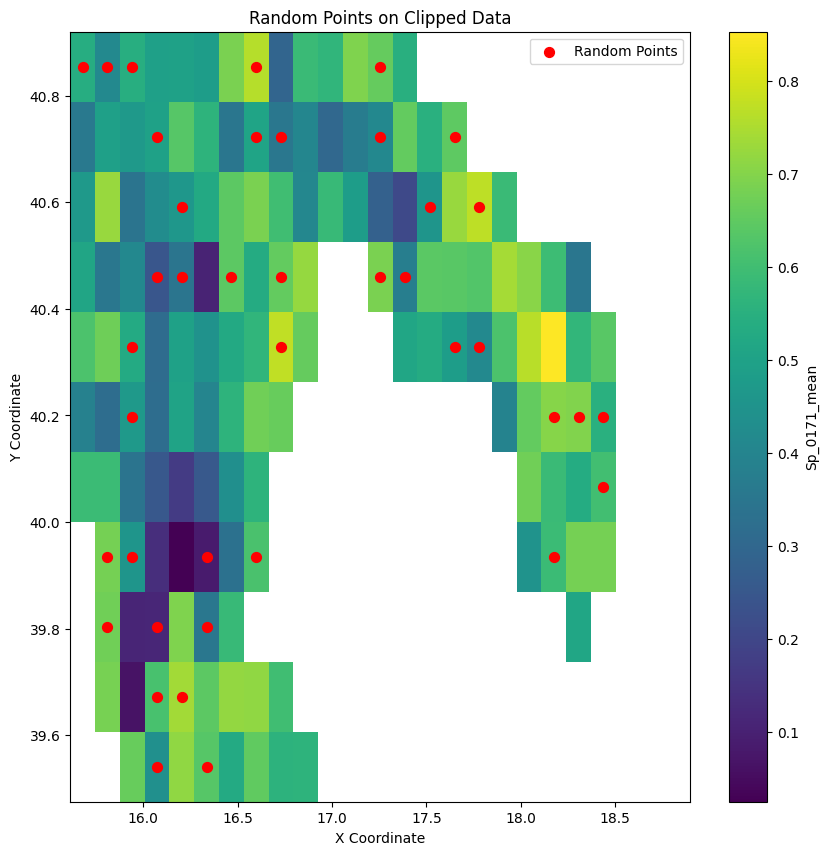

In [28]:
import matplotlib.pyplot as plt

# Plot the clipped data
fig, ax = plt.subplots(figsize=(10, 10))
subset.plot(ax=ax)

# Plot the random points
ax.scatter(random_points[:, 0], random_points[:, 1], color='red', marker='o', s=50, label='Random Points')

# Add labels and legend
ax.set_title('Random Points on Clipped Data')
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')
ax.legend()

plt.show()

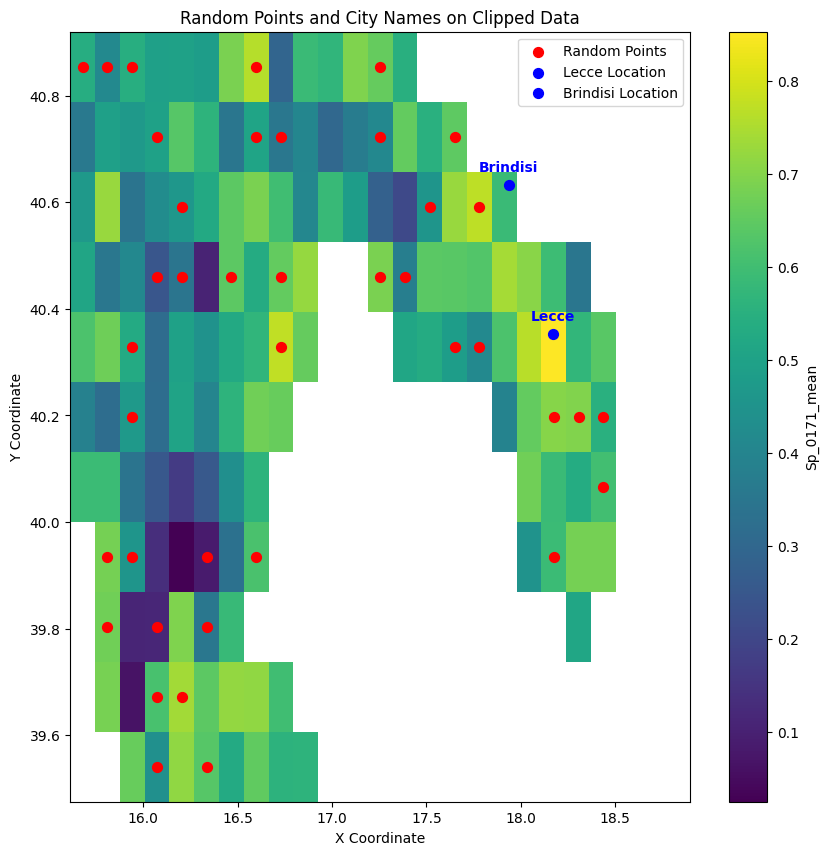

In [37]:
# Define city names and their coordinates
cities = {
    "Lecce": (18.1710, 40.3529),
    "Brindisi": (17.9373, 40.6327)
}

# Plot the clipped data
fig, ax = plt.subplots(figsize=(10, 10))
subset.plot(ax=ax)

# Plot the random points
ax.scatter(random_points[:, 0], random_points[:, 1], color='red', marker='o', s=50, label='Random Points')

# Add city names to the plot
for city, (lon, lat) in cities.items():
    x, y = transformer.transform(lon, lat, direction='INVERSE')
    ax.annotate(f'{city}', (x, y), textcoords="offset points", xytext=(0,10), ha='center', color='blue', fontweight='bold')
    ax.scatter(lon, lat, color='blue', marker='o', s=50, label=f'{city} Location')

# Add labels and legend
ax.set_title('Random Points and City Names on Clipped Data')
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')
ax.legend()

plt.show()

>**Note:** each cell in the grided data represents the species richness at that location. Each grid represent 10x10 KM area.

For each point in the map, download the corresponding soil data:

In [38]:
from pyproj import Transformer
# Convert each point to EPSG:4326 and create a list of dictionaries
coordinates_list = []
for point in random_points:
    lon, lat = transformer.transform(point[0], point[1])
    coordinates_list.append({"lat": lat, "lon": lon})

print(coordinates_list)

[{'lat': 40.59178710377054, 'lon': 17.517819779873445}, {'lat': 40.8545648540347, 'lon': 16.5980976539489}, {'lat': 40.46039822863847, 'lon': 16.466708778816827}, {'lat': 40.19762047837431, 'lon': 18.174764155533833}, {'lat': 40.46039822863847, 'lon': 16.20393102855267}, {'lat': 40.19762047837431, 'lon': 15.941153278288514}, {'lat': 39.934842728110155, 'lon': 15.941153278288514}, {'lat': 40.8545648540347, 'lon': 15.678375528024358}, {'lat': 39.934842728110155, 'lon': 16.335319903684745}, {'lat': 40.8545648540347, 'lon': 15.80976440315644}, {'lat': 39.934842728110155, 'lon': 16.5980976539489}, {'lat': 39.672064977846006, 'lon': 16.07254215342059}, {'lat': 39.80345385297808, 'lon': 16.335319903684745}, {'lat': 40.32900935350639, 'lon': 15.941153278288514}, {'lat': 40.723175978902624, 'lon': 17.64920865500552}, {'lat': 40.8545648540347, 'lon': 15.941153278288514}, {'lat': 40.59178710377054, 'lon': 16.20393102855267}, {'lat': 39.80345385297808, 'lon': 15.80976440315644}, {'lat': 39.6720649

In [ ]:
from soilgrids import data_processing as dprc

for coord in coordinates_list:
    dprc.data_processing(coord)

In [41]:
import pandas as pd
import glob
import re

# Get a list of all soil.txt files in the soilDataPrepared directory
file_list = glob.glob('soilDataPrepared/*_soil.txt')

# Initialize an empty list to store dataframes
df_list = []

# Loop through each file and read it into a dataframe
for file in file_list:
    # Extract latitude and longitude from the file name
    match = re.search(r'lat([-\d.]+)_lon([-\d.]+)', file)
    if match:
        lat = float(match.group(1))
        lon = float(match.group(2))
    
    # Read the file into a dataframe
    df = pd.read_csv(file, sep='\t', skiprows=2)  # Assuming the files are tab-separated
    
    # Add latitude and longitude as new columns
    df['Latitude'] = lat
    df['Longitude'] = lon
    
    # Append the dataframe to the list
    df_list.append(df)

# Concatenate all dataframes into a single dataframe
soil_data_df = pd.concat(df_list, ignore_index=True)

print(soil_data_df)

     Layer  FC[V%]  PWP[V%]  POR[V%]  KS[mm/d]   Latitude  Longitude
0      1.0  39.465   13.530   47.115  220.3940  39.672065  16.072542
1      2.0  37.990   13.515   45.315  206.8305  39.672065  16.072542
2      3.0  37.920   13.960   44.650  189.7080  39.672065  16.072542
3      4.0  39.440   14.000   43.870   59.7050  39.672065  16.072542
4      5.0  39.440   14.000   43.870   59.7050  39.672065  16.072542
..     ...     ...      ...      ...       ...        ...        ...
455   16.0  37.250   14.390   40.790   68.0900  40.854565  16.598098
456   17.0  37.250   14.390   40.790   68.0900  40.854565  16.598098
457   18.0  37.250   14.390   40.790   68.0900  40.854565  16.598098
458   19.0  37.250   14.390   40.790   68.0900  40.854565  16.598098
459   20.0  37.250   14.390   40.790   68.0900  40.854565  16.598098

[460 rows x 7 columns]


In [42]:
# Initialize an empty list to store species richness values
species_richness_values = []

# Loop through each row in the dataframe
for index, row in soil_data_df.iterrows():
    # Get the latitude and longitude
    lat = row['Latitude']
    lon = row['Longitude']
    
    # Get the corresponding species richness value from the subset dataset
    species_richness = subset.sel(x=lon, y=lat, method='nearest').values[0]
    
    # Append the species richness value to the list
    species_richness_values.append(species_richness)

# Add the species richness values as a new column in the dataframe
soil_data_df['Species_Richness'] = species_richness_values

print(soil_data_df)

     Layer  FC[V%]  PWP[V%]  POR[V%]  KS[mm/d]   Latitude  Longitude  \
0      1.0  39.465   13.530   47.115  220.3940  39.672065  16.072542   
1      2.0  37.990   13.515   45.315  206.8305  39.672065  16.072542   
2      3.0  37.920   13.960   44.650  189.7080  39.672065  16.072542   
3      4.0  39.440   14.000   43.870   59.7050  39.672065  16.072542   
4      5.0  39.440   14.000   43.870   59.7050  39.672065  16.072542   
..     ...     ...      ...      ...       ...        ...        ...   
455   16.0  37.250   14.390   40.790   68.0900  40.854565  16.598098   
456   17.0  37.250   14.390   40.790   68.0900  40.854565  16.598098   
457   18.0  37.250   14.390   40.790   68.0900  40.854565  16.598098   
458   19.0  37.250   14.390   40.790   68.0900  40.854565  16.598098   
459   20.0  37.250   14.390   40.790   68.0900  40.854565  16.598098   

     Species_Richness  
0            0.611665  
1            0.611665  
2            0.611665  
3            0.611665  
4            0.

In [43]:
# Calculate the correlation matrix
correlation_matrix = soil_data_df.corr()

# Extract the correlation values for Species_Richness
species_richness_correlation = correlation_matrix["Species_Richness"]

print(species_richness_correlation)

Layer              -9.389675e-17
FC[V%]             -4.949208e-01
PWP[V%]            -7.489635e-02
POR[V%]            -3.840054e-01
KS[mm/d]            2.762414e-01
Latitude           -7.859596e-03
Longitude           1.260914e-01
Species_Richness    1.000000e+00
Name: Species_Richness, dtype: float64
